In [1]:
import pandas as pd
from dgllife.utils import ScaffoldSplitter
import torch.nn as nn
import torch
from dgllife.model import GATPredictor
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import EarlyStopping
from torch.optim import Adam
from torch.utils.data import DataLoader
import xgboost
import shap
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import json

from data_loader import CancerMolecules, collate, run_a_train_epoch, run_an_eval_epoch, make_timestamp
import seaborn as sns
from torch.nn import ELU

sns.set()
sns.set_context('talk')

Using backend: pytorch


In [2]:
data = CancerMolecules(purpose='training', use_ccri_negatives=False)
# need smiles data?
split = ScaffoldSplitter()
train, val, test = split.train_val_test_split(data)

Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
Invalid mol found
0.0    4815
1.0    3015
dtype: int64
Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7830
Creating RDKit molecule instance 2000/7830
Creating RDKit molecule instance 3000/7830
Creating RDKit molecule instance 4000/7830
Creating RDKit molecule instance 5000/7830
Creating RDKit molecule instance 6000/7830
Creating RDKit molecule instance 7000/7830
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7830
Computing Bemis-Murcko for compound 2000/7830
Computing Bemis-Murcko for compound 3000/7830
Computing Bemis-Murcko 

In [3]:
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')

def featurize(g):
    features = torch.cat(
        [g.edata['h'].std(axis=0), g.edata['h'].mean(axis=0), g.edata['h'].sum(axis=0),
         g.ndata['h'].std(axis=0),g.ndata['h'].mean(axis=0),g.ndata['h'].sum(axis=0)
    ]).numpy()
    return features

feat_names = pd.read_csv('../data/feature_names.txt',names=['feature_names'])

In [4]:
def prep_data(dataset, feat_names=feat_names):
    df_data = pd.DataFrame(np.array([featurize(x) for x in dataset.graphs]),
                           columns=feat_names.values.flatten())
    label_data = dataset.labels.numpy().flatten().astype(bool)
    loader_data = DataLoader(
        dataset=dataset,
        batch_size=128,
        shuffle=False,
        collate_fn=collate,
        num_workers=1
    )
    xgboost_data = xgboost.DMatrix(
        df_data, 
        label=label_data
    )

    return df_data, label_data, xgboost_data, loader_data


In [5]:
held_out_test = CancerMolecules(purpose='test', use_ccri_negatives=False)
(held_out_test_data, held_out_test_label, 
 d_held_out_test, held_out_test_loader) = prep_data(held_out_test)

caps_val = CancerMolecules(purpose='caps_val', use_ccri_negatives=False)
(caps_val_data, caps_val_label, 
 d_caps_val, caps_val_loader) = prep_data(caps_val)

(train_data, train_label,
 d_train, train_loader) = prep_data(train.dataset)

(val_data, val_label, 
d_val, val_loader) = prep_data(val.dataset)

(test_data, test_label,
 d_test, test_loader) = prep_data(test.dataset)

Invalid mol found
Invalid mol found
0.0    295
1.0    203
dtype: int64
1.0    23
0.0    17
dtype: int64


In [8]:
# Train XGBoost model
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(val_label),
    "eval_metric": "logloss"
}
xgboost_model = xgboost.train(
    params, d_train,
    10000, evals = [(d_val, "test")],
    verbose_eval=500, early_stopping_rounds=20
)

[0]	test-logloss:0.66257
[500]	test-logloss:0.28463
[1000]	test-logloss:0.21407
[1500]	test-logloss:0.16871
[2000]	test-logloss:0.13631
[2500]	test-logloss:0.11306
[3000]	test-logloss:0.09506
[3500]	test-logloss:0.08153
[4000]	test-logloss:0.07098
[4500]	test-logloss:0.06290
[5000]	test-logloss:0.05626
[5500]	test-logloss:0.05107
[6000]	test-logloss:0.04678
[6500]	test-logloss:0.04310
[7000]	test-logloss:0.03997
[7500]	test-logloss:0.03737
[8000]	test-logloss:0.03502
[8500]	test-logloss:0.03305
[9000]	test-logloss:0.03132
[9500]	test-logloss:0.02981
[9999]	test-logloss:0.02842


In [9]:
def load_model(timestamp, directory='../models/01_gat/'):
    with open(f'{directory}{timestamp}.config') as fin:
        config = json.load(fin)
    args = {x[0]:x[1]['value'] for x in  config.items()}
    
    model = GATPredictor(
        in_feats = args["in_feats"],
        hidden_feats = [args['hidden_feats'] for _ in range(args['nlayers'])],
        num_heads = [args['num_heads'] for _ in range(args['nlayers'])],
        feat_drops = [args['feat_drops'] for _ in range(args['nlayers'])],
        attn_drops = [args['attn_drops'] for _ in range(args['nlayers'])],
        alphas = args['alphas'],
        residuals = args['residuals'],
        agg_modes = args['agg_modes'],
        activations = [
            ELU(alpha=args['alphas'][i]) for i in range(args['nlayers'] - 1)
        ] + [None],
        n_tasks = args['n_tasks'],
        predictor_hidden_feats = args['predictor_hidden_feats'],
        predictor_dropout = args['predictor_dropout'],
    )

    model.load_state_dict(
        torch.load(f'{directory}{timestamp}', map_location=torch.device('cpu'))
    )
    return model,args

def run_evaluation(model, data_loader):
    model.eval()
    all_pred = []
    all_labels = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            bg, labels = batch_data
            labels = labels.view(-1, 1)
            node_feats = bg.ndata.pop('h')
            logits = model(bg, node_feats)
            
            all_labels.append(labels.numpy().flatten())
            all_pred.append(logits.numpy().flatten())
    return np.concatenate(all_pred), np.concatenate(all_labels)


def run_ensemble_evaluation(models, data_loader):
    assert len(models) > 1
    pred, labels = run_evaluation(models[0], data_loader)
    all_pred = [pred]
    for model in models[1:]:
        new_pred, new_labels = run_evaluation(model, data_loader)
        assert all(labels == new_labels)
        all_pred.append(new_pred)
    
    pred = np.array(all_pred).mean(axis=0)
    return pred, labels
        

In [10]:
def add_pr_plot(prediction, labels, name):
    precision, recall, thresholds = precision_recall_curve(labels, prediction)
    auc_value = auc(recall, precision)
    plt.step(recall, precision, where='post', label=f'{name} AUC: {round(auc_value, 3)}')
    
def add_roc_plot(prediction, labels, name):
    fpr, tpr, thresholds = roc_curve(labels, prediction)
    auc_value = auc(fpr, tpr)
    plt.step(fpr, tpr, where='post', label=f'{name} AUC: {round(auc_value, 3)}')


In [11]:
model_1neg, _ = load_model('2021_04_15_14_04_21', directory='../models/02_gat_negatives/')
model_2neg, _ = load_model('2021_04_15_15_36_32', directory='../models/02_gat_negatives/')
model_3neg, _ = load_model('2021_04_15_16_38_39', directory='../models/02_gat_negatives/')
model_4neg, _ = load_model('2021_04_15_16_57_10', directory='../models/02_gat_negatives/')
model_5neg, _ = load_model('2021_04_15_17_04_42', directory='../models/02_gat_negatives/')
model_6neg, _ = load_model('2021_04_15_17_16_06', directory='../models/02_gat_negatives/')

preds, labels = run_ensemble_evaluation(
    [model_1neg, model_2neg, model_3neg, model_4neg, model_5neg, model_6neg],
    held_out_test_loader
)
assert len(labels) == len(preds)

In [12]:
model1, _ = load_model('2021_04_15_01_41_00')
model2, _ = load_model('2021_04_15_03_44_21')
model3, _ = load_model('2021_04_15_02_43_38')
model4, _ = load_model('2021_04_15_00_12_21')
model5, _ = load_model('2021_04_15_04_57_56')
model6, _ = load_model('2021_04_15_07_05_05')

preds, labels = run_ensemble_evaluation(
    [model1, model2, model3, model4, model5, model6],
    held_out_test_loader
)
assert len(labels) == len(preds)

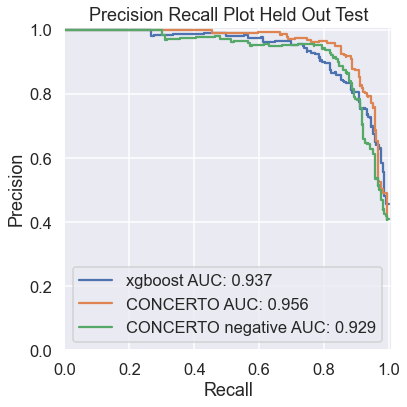

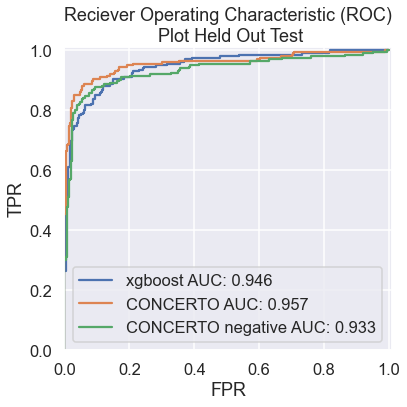

In [34]:
figure_size = 6

held_out_predictions = xgboost_model.predict(d_held_out_test)
gat_pred, gat_labels = run_evaluation(model1, held_out_test_loader)
ensemble_preds, ensemble_labels = run_ensemble_evaluation(
    [model1, model2, model3, model4, model5, model6],
    held_out_test_loader
)
gat_pred_neg, gat_labels_neg = run_evaluation(model_1neg, held_out_test_loader)
ensemble_preds_neg, ensemble_labels_neg = run_ensemble_evaluation(
    [model_1neg, model_2neg, model_3neg, model_4neg, model_5neg, model_6neg],
    held_out_test_loader
)


assert all(held_out_test_label.astype(int) == gat_labels)
assert all(held_out_test_label.astype(int) == ensemble_labels)
assert all(held_out_test_label.astype(int) == gat_labels_neg)
assert all(held_out_test_label.astype(int) == ensemble_labels_neg)

plt.figure(figsize=(figure_size, figure_size))
add_pr_plot(held_out_predictions ,held_out_test_label, 'xgboost')
# add_pr_plot(pred1, labels1, 'gat1')
add_pr_plot(ensemble_preds, ensemble_labels, 'CONCERTO')
# add_pr_plot(gat_pred_neg, gat_labels_neg, 'gat_negative')
add_pr_plot(ensemble_preds_neg, ensemble_labels_neg, 'CONCERTO negative')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.title('Precision Recall Plot Held Out Test')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/pr_held_out_test.pdf')

plt.show()

plt.figure(figsize=(figure_size, figure_size))
add_roc_plot(held_out_predictions ,held_out_test_label, 'xgboost')
# add_roc_plot(pred1, labels1, 'gat1')
add_roc_plot(ensemble_preds, ensemble_labels, 'CONCERTO')
# add_roc_plot(gat_pred_neg, gat_labels_neg, 'gat_negative')
add_roc_plot(ensemble_preds_neg, ensemble_labels_neg, 'CONCERTO negative')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.title("Reciever Operating Characteristic (ROC)\n Plot Held Out Test")
plt.legend()
plt.tight_layout()
plt.savefig('../plots/roc_held_out_test.pdf')

plt.show()

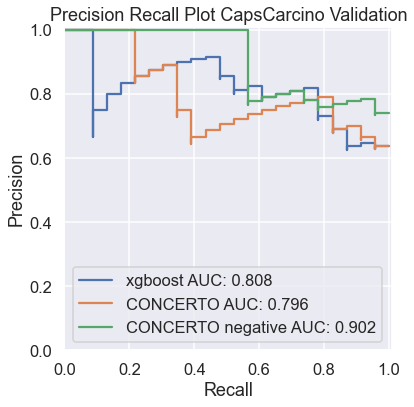

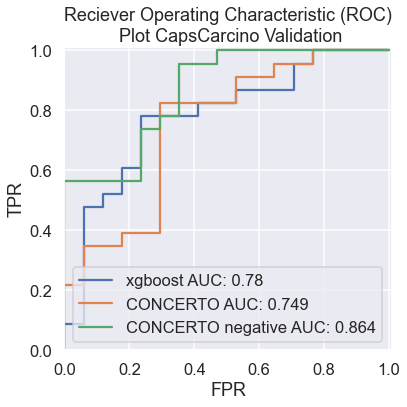

In [33]:
figure_size=6

xgboost_pred = xgboost_model.predict(d_caps_val)
gat_pred, gat_labels = run_evaluation(model1, caps_val_loader)
ensemble_preds, ensemble_labels = run_ensemble_evaluation(
    [model1, model2, model3, model4, model5, model6],
    caps_val_loader
)
gat_pred_neg, gat_labels_neg = run_evaluation(model_1neg, caps_val_loader)
ensemble_preds_neg, ensemble_labels_neg = run_ensemble_evaluation(
    [model_1neg, model_2neg, model_3neg, model_4neg, model_5neg, model_6neg],
    caps_val_loader
)

assert all(caps_val_label.astype(int) == gat_labels)
assert all(caps_val_label.astype(int) == ensemble_labels)
assert all(caps_val_label.astype(int) == gat_labels_neg)
assert all(caps_val_label.astype(int) == ensemble_labels_neg)

plt.figure(figsize=(figure_size, figure_size))

add_pr_plot(xgboost_pred ,caps_val_label, 'xgboost')
# add_pr_plot(gat_pred, gat_labels, 'gat1')
add_pr_plot(ensemble_preds, ensemble_labels, 'CONCERTO')
# add_pr_plot(gat_pred_neg, gat_labels_neg, 'gat_negative')
add_pr_plot(ensemble_preds_neg, ensemble_labels_neg, 'CONCERTO negative')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])#0.938
plt.title('Precision Recall Plot CapsCarcino Validation')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/pr_capscarcino_validation.pdf')
plt.show()

plt.figure(figsize=(figure_size, figure_size))
add_roc_plot(xgboost_pred ,caps_val_label, 'xgboost')
# add_roc_plot(gat_pred, gat_labels, 'gat1')
add_roc_plot(ensemble_preds, ensemble_labels, 'CONCERTO')
# add_roc_plot(gat_pred_neg, gat_labels_neg, 'gat_negative')
add_roc_plot(ensemble_preds_neg, ensemble_labels_neg, 'CONCERTO negative')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.title("Reciever Operating Characteristic (ROC)\n Plot CapsCarcino Validation")
plt.legend()
plt.tight_layout()
plt.savefig('../plots/roc_capscarcino_validation.pdf')
plt.show()


In [15]:
ensemble_preds_neg, ensemble_labels_neg = run_ensemble_evaluation(
    [model_1neg, model_2neg, model_3neg, model_4neg, model_5neg, model_6neg],
    held_out_test_loader
)


[4.5279603 5.261535  5.144071  5.1787286 5.9839168 6.268966  6.4016557
 6.2342515 6.2544785 6.223964  6.4401283 6.540219  6.65527   6.777475
 7.217119 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


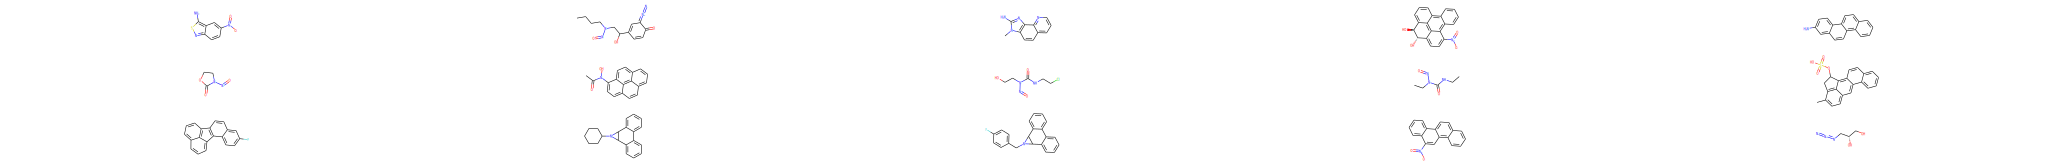

In [19]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw

ind = np.argpartition(ensemble_preds_neg, -5)[-15:]
print(ensemble_preds_neg[ind])
print(ensemble_labels_neg[ind])
least_carc_smiles = [held_out_test.smiles[i] for i in ind ]
mols = [Chem.MolFromSmiles(s) for s in least_carc_smiles]
image = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(1500, 200), useSVG=True)

with open('../plots/carcinogenic.svg', 'w') as fout:
    fout.write(image)
SVG(image)

[-5.324943  -5.688659  -5.3890605 -5.8184547 -6.8010917]
[0. 0. 0. 0. 0.]


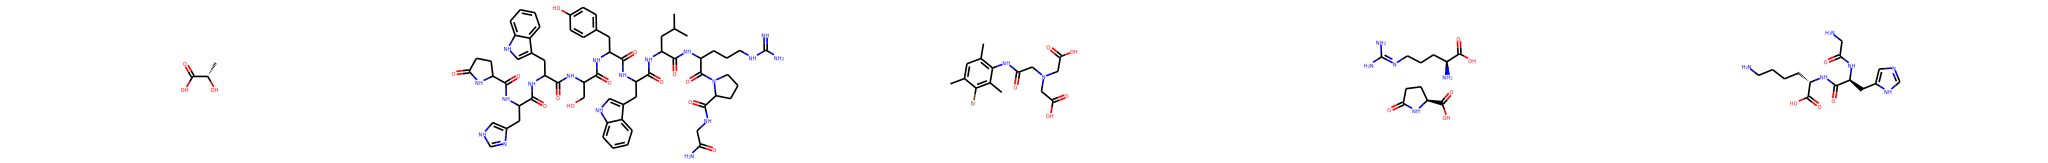

In [20]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw


ind = np.argpartition(ensemble_preds_neg, 5)[10:15]
print(ensemble_preds_neg[ind])
print(ensemble_labels_neg[ind])
most_carc_smiles = [held_out_test.smiles[i] for i in ind ]
mols = [Chem.MolFromSmiles(s) for s in most_carc_smiles]
image = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(500, 200), useSVG=True)

with open('../plots/non_carcinogenic.svg', 'w') as fout:
    fout.write(image)
SVG(image)

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_data)

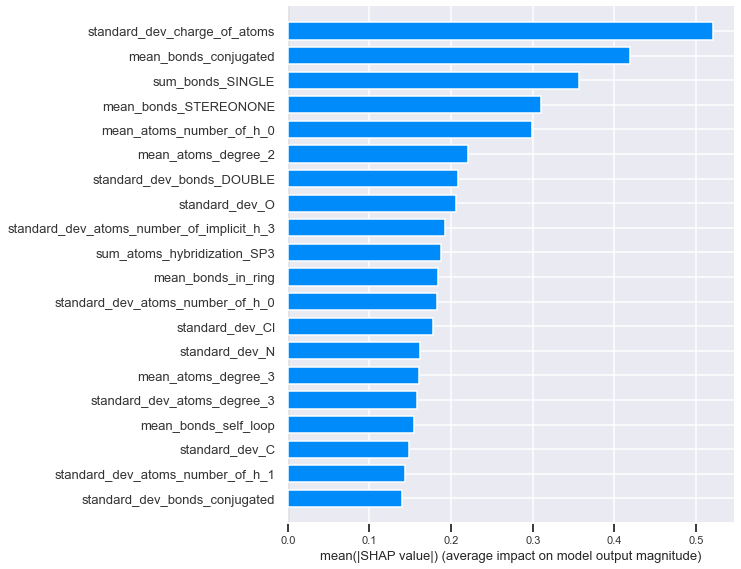

In [16]:
shap.initjs()
shap_values = explainer.shap_values(test_data)
shap.force_plot(explainer.expected_value, shap_values[0,:], test_data.iloc[0])
shap.summary_plot(shap_values, test_data, plot_type="bar")

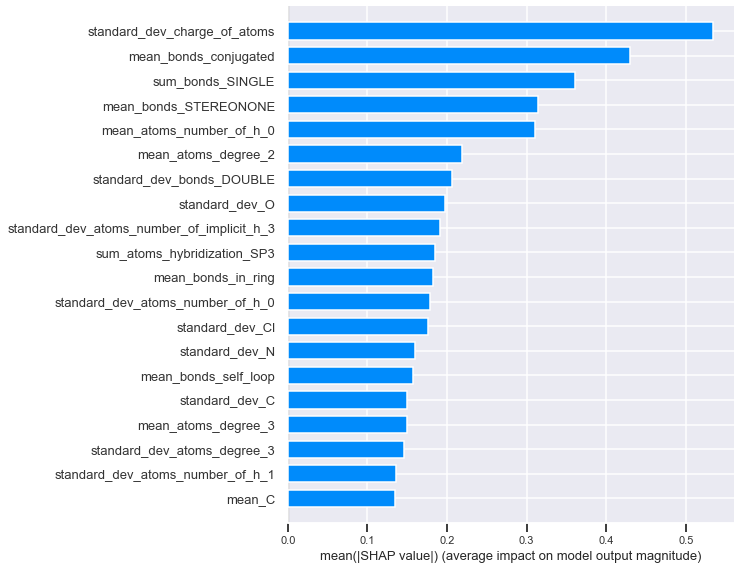

In [17]:
shap.initjs()
shap_values = explainer.shap_values(held_out_test_data)
shap.force_plot(explainer.expected_value, shap_values[0,:], held_out_test_data.iloc[0])
shap.summary_plot(shap_values, held_out_test_data, plot_type="bar")